In [1]:
#RUN THIS CELL
import os
import pathlib
working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
print(working_dir)
os.chdir(working_dir)

D:\Programing and Tech\Python\Projects\Univ. AI Projects\HW 2


In [2]:
import requests
import zipfile
import shutil
import json
import time
import sys
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


In [3]:
from PIL import Image

from scipy.signal import convolve2d
import scipy.ndimage as ndimage

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

#Some imports for getting the CIFAR-10 dataset and for help with visualization*]
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils import layer_utils
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam


from sklearn.metrics import mean_squared_error
import certifi
import urllib3  # For handling https certificate verification 
import scipy.ndimage as ndimage

%matplotlib inline

In [4]:
seed_value=111
import random
random.seed(seed_value)
#os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

**Helper code to generate feature maps**

In [5]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

**A dictionary to turn class index into class labels for CIFAR-10**

In [6]:
cifar10dict = {0 : 'airplane', 1 : 'automobile', 2 : 'bird', 3 : 'cat', 4 : 'deer', 5 : 'dog', 6 : 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

## Data Loading and Preproccessing

In [7]:
#loading data from CIFAR10
(X_train,y_train),(X_test,y_test) = cifar10.load_data()
#one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#Image preprocessing: Normalization and fixing the data type
def prep_pixels(train,test):
    """
    Parameters:
        Train: X_train dataset
        Test: X_test dataset
    Return:
        Normailized dataset equivalents of X_train and X_test
    """
    #convert the pixels from int to float
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    #normalize the range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    #returning the values
    return train_norm, test_norm
X_train,X_test = prep_pixels(X_train,X_test)

In [8]:
print("Shape of Dataset: X_Train: {}, y_train: {}, X_test: {}, y_test: {}".format(X_train.shape,y_train.shape,X_test.shape,y_test.shape))

Shape of Dataset: X_Train: (50000, 32, 32, 3), y_train: (50000, 10), X_test: (10000, 32, 32, 3), y_test: (10000, 10)


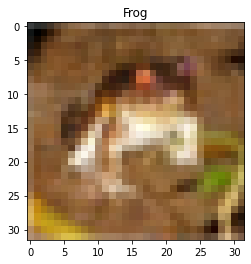

In [9]:
#ploting one of the images
img = X_train[0]
plt.title('Frog')
plt.imshow(img)
plt.show()

# 1. Model Construction

In [10]:
#Constructing a dummy model for the exercise
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same',input_shape=(32,32,3)))
for i in [32,48,64,80,96,112,128]:
    model.add(Conv2D(filters=i,kernel_size=(3,3),activation='relu',padding='same'))

model.compile(loss='categorical_crossentropy',optimizer=SGD(lr=0.001,momentum=0.9),metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 48)        13872     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 80)        46160     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 96)        69216     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 112)       9

In [12]:
# your code here
print("Total weigths: {}".format(model.count_params()))

Total weigths: 388080


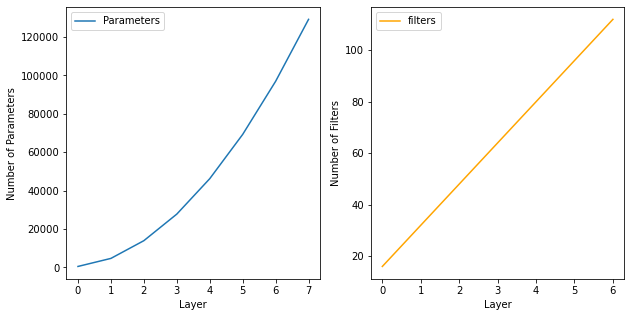

In [13]:
n_params=[]
filters = np.array(range(16,128,16))
for layer in model.layers:
    n_params.append(layer.count_params())
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(n_params, label='Parameters')
ax[0].set_xlabel('Layer')
ax[0].set_ylabel('Number of Parameters')
ax[1].plot(filters, color='orange', label='filters')
ax[1].set_xlabel('Layer')
ax[1].set_ylabel('Number of Filters')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.show()

The number of parameters increase exponentially with increase in convolution layer and those convolution layers have a linear increase in filtes at 16 filter increments

The increase in parameters with respect to number of filters in a convlution layer is ``linear``

The reason for the relation is simple since the kernel_size is same for all layers number of parameters for a layer i are calculated using the following function:

``n_params[i] = 3 x 3 x n_filters[i] x n_filters[i-1] + n_filters[i]``

The function is a linear relation between number of filters in a layer and number of paramters of the layers. We just see this linear relation through experimentation in the above graph

In [14]:
#Construct the CNN model
CNN = Sequential()

#regularization
L2 = tf.keras.regularizers.l2(0.001)

CNN.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(32,32,3)))
CNN.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
CNN.add(MaxPooling2D(pool_size=(2,2),strides=2))

CNN.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
CNN.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
CNN.add(MaxPooling2D(pool_size=(2,2),strides=2))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
CNN.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
CNN.add(MaxPooling2D(pool_size=(2,2),strides=2))
CNN.add(Dropout(0.2))

CNN.add(Flatten())
CNN.add(Dense(128, kernel_regularizer=L2, activation='relu'))
CNN.add(Dropout(0.2))
CNN.add(Dense(10, kernel_regularizer=L2, activation='softmax'))



In [15]:
#compile the model
CNN.compile(loss='categorical_crossentropy',optimizer=SGD(lr=0.001,momentum=0.9),metrics=['accuracy'])

In [16]:
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)         

In [17]:
#callback = tf.keras.callbacks.EarlyStopping(patience=10)
history = CNN.fit(X_train,y_train,epochs=20,batch_size=32,validation_split=0.2, shuffle=False)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 11s 283us/sample - loss: 2.4186 - accuracy: 0.1863 - val_loss: 2.2004 - val_accuracy: 0.2943
Epoch 2/20
40000/40000 [==============================] - 9s 220us/sample - loss: 2.0971 - accuracy: 0.3273 - val_loss: 1.8882 - val_accuracy: 0.4102
Epoch 3/20
40000/40000 [==============================] - 9s 217us/sample - loss: 1.8693 - accuracy: 0.4065 - val_loss: 1.7902 - val_accuracy: 0.4403
Epoch 4/20
40000/40000 [==============================] - 8s 212us/sample - loss: 1.7298 - accuracy: 0.4531 - val_loss: 1.6990 - val_accuracy: 0.4725
Epoch 5/20
40000/40000 [==============================] - 8s 207us/sample - loss: 1.6198 - accuracy: 0.4916 - val_loss: 1.5432 - val_accuracy: 0.5229
Epoch 6/20
40000/40000 [==============================] - 8s 210us/sample - loss: 1.5279 - accuracy: 0.5239 - val_loss: 1.4543 - val_accuracy: 0.5540
Epoch 7/20
40000/40000 [=========================

In [18]:
#predict using the model
y_pred = CNN.predict(X_test)
print("Mean Squared Error of the Model: {}".format(mean_squared_error(y_test,y_pred)))

Mean Squared Error of the Model: 0.03635605424642563


In [19]:
#model evaluation
acc = CNN.evaluate(X_test,y_test,verbose=0)
acc2 = CNN.evaluate(X_train,y_train, verbose=0)
print("Evaluate on test data")
print("Test Loss: {}, Test Acc: {}".format(acc[0],acc[1]))
print('Evaluating on the Train Data')
print(f'Train Loss: {acc2[0]}, Train Acc: {acc2[1]}')

Evaluate on test data
Test Loss: 0.8932608071327209, Test Acc: 0.7336000204086304
Evaluating on the Train Data
Train Loss: 0.6848443984222412, Train Acc: 0.8122000098228455


"filename = sys.argv[0].split('/')[-1]\nplt.savefig(filename + '_plot.png')\nplt.close()"

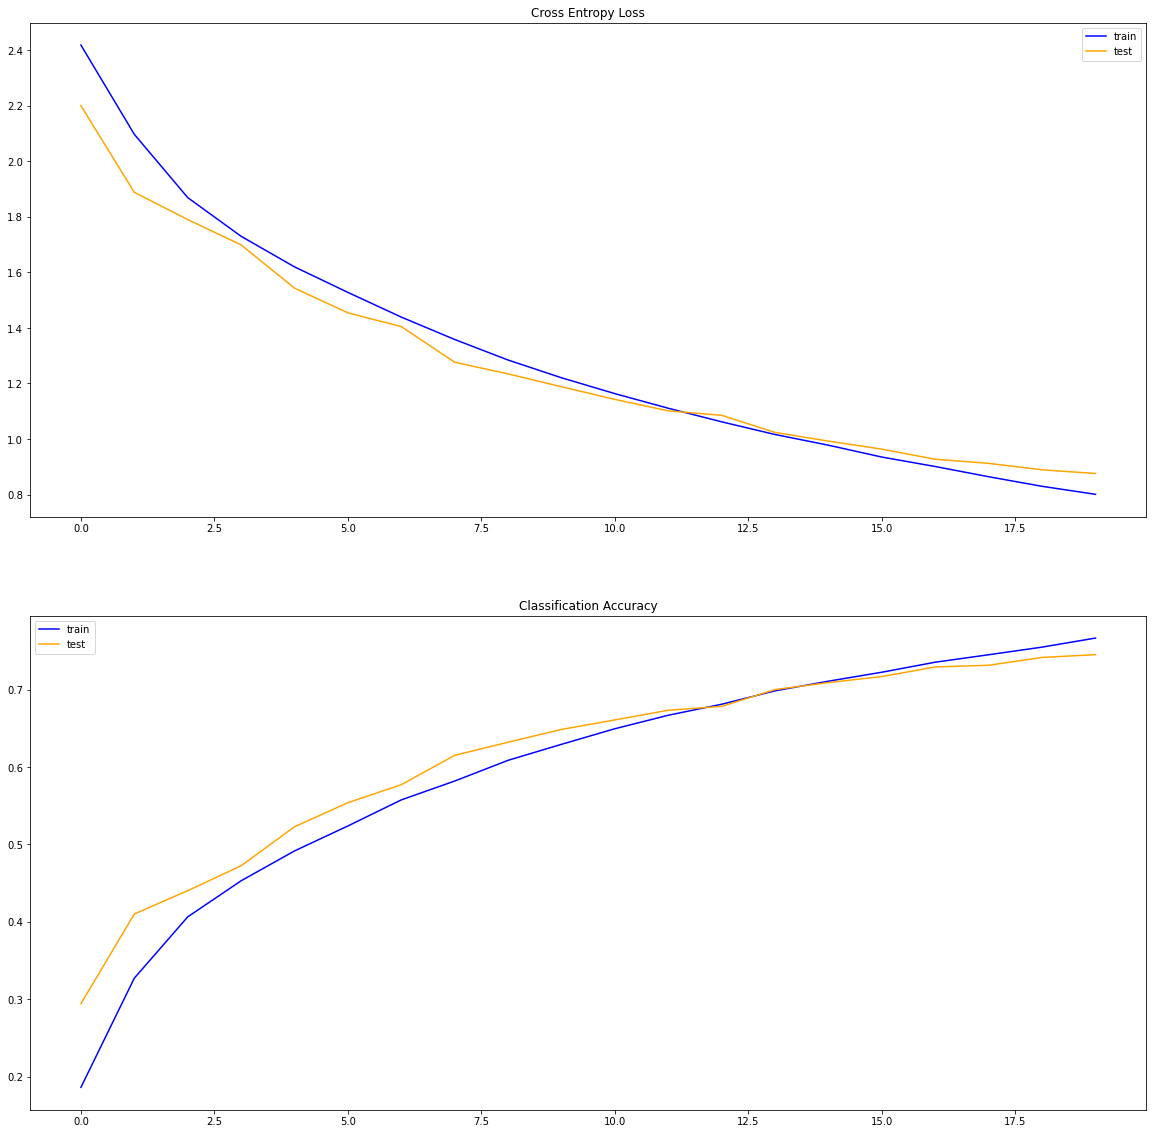

In [20]:
#Plotting Loss and Accuracy scores
fig, axs = plt.subplots(2,1,figsize=(20,20))
axs[0].title.set_text('Cross Entropy Loss')
axs[0].plot(history.history['loss'], color='blue', label='train')
axs[0].plot(history.history['val_loss'], color='orange', label='test')
axs[0].legend()
axs[1].title.set_text('Classification Accuracy')
axs[1].plot(history.history['accuracy'], color='blue', label='train')
axs[1].plot(history.history['val_accuracy'], color='orange', label='test')
axs[1].legend()
# save plot to file
"""filename = sys.argv[0].split('/')[-1]
plt.savefig(filename + '_plot.png')
plt.close()"""

# 1.3 Feature Mapping

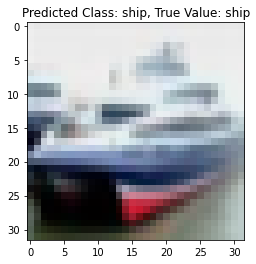

In [21]:
#getting the first image that was classified correctly
image_id = np.where(y_pred.argmax(axis=1) == y_test.argmax(axis=1))[0][0]

display = [cifar10dict[np.argmax(y_pred[image_id])],cifar10dict[np.argmax(y_test[image_id])]]
plt.title(f'Predicted Class: {display[0]}, True Value: {display[1]}')
plt.imshow(X_test[image_id])
plt.show()

In [22]:
feature_maps = get_feature_maps(CNN,3,X_test[image_id])
print(feature_maps.shape)

(64, 16, 16)


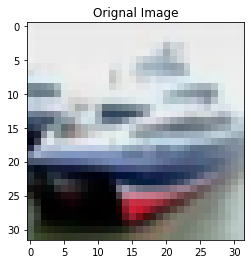

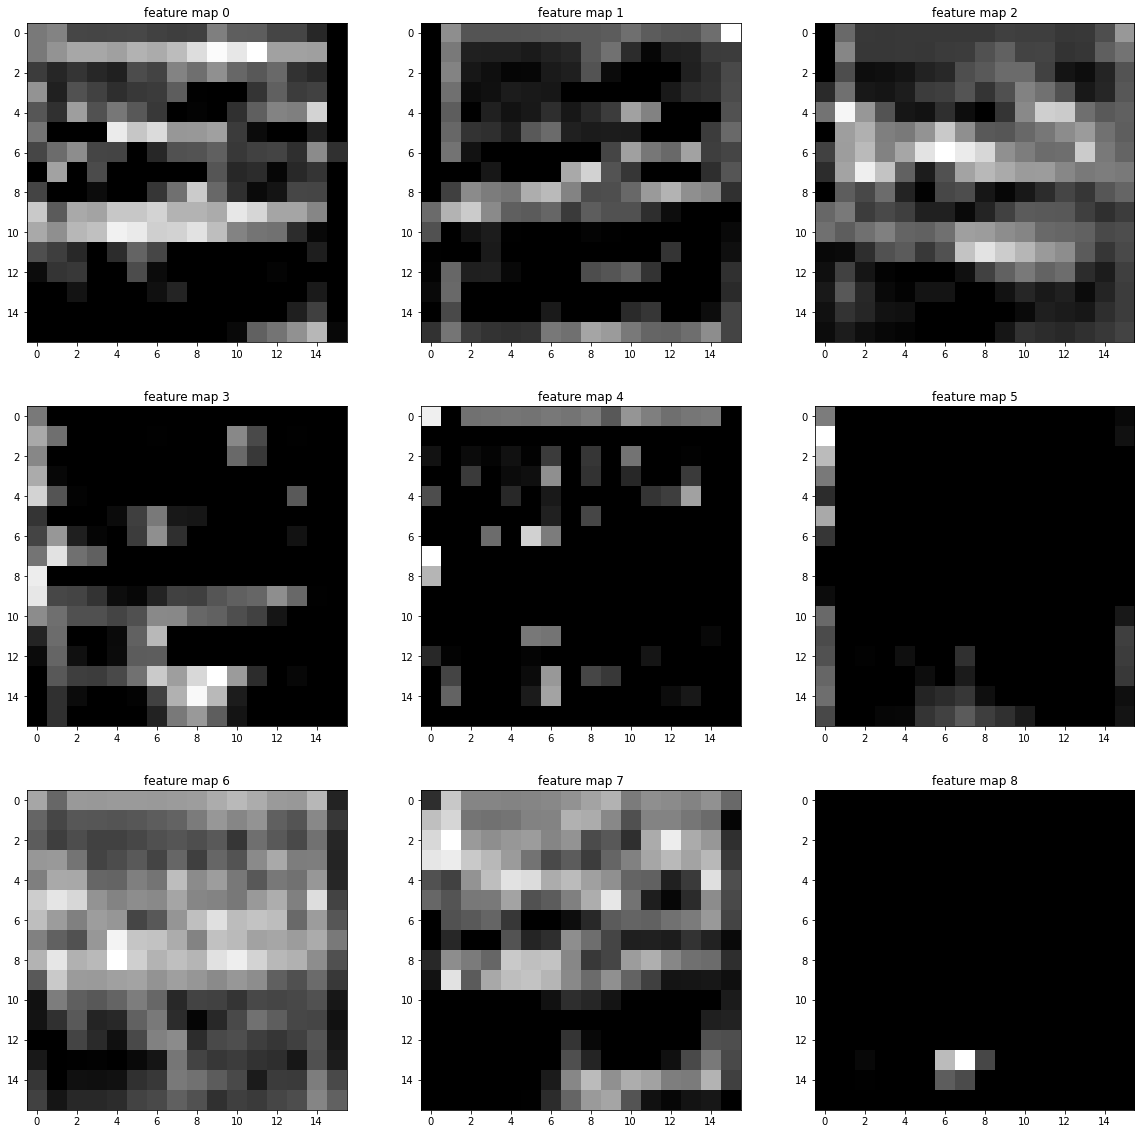

In [23]:
plt.title('Orignal Image')
plt.imshow(X_test[image_id])
plt.show()
fig, axs = plt.subplots(3,3,figsize=(20,20))
for i,ax in enumerate(axs.ravel()):
    ax.title.set_text('feature map {}'.format(i))
    ax.imshow(feature_maps[i],cmap='gray')

# Saliency Maps, GradCAM

#### Correct Classification

In [24]:
#SALIENCY MAP
class_idx = y_test[image_id].argmax() #gives the number label for the correctly classified image
def loss(output):
    return output[:, class_idx]

#creating a Saliency object
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
saliency = Saliency(CNN, model_modifier = model_modifier, clone=True)

#Generate Saliency map
saliency_map = saliency(loss=loss,seed_input=X_test[image_id],smooth_samples=20,smooth_noise=0.20)

In [25]:
#GRADCAM
gradcam = Gradcam(CNN, model_modifier = model_modifier, clone=True)
#Genertate Heat map
cam = gradcam(loss,X_test[image_id],penultimate_layer=-1)


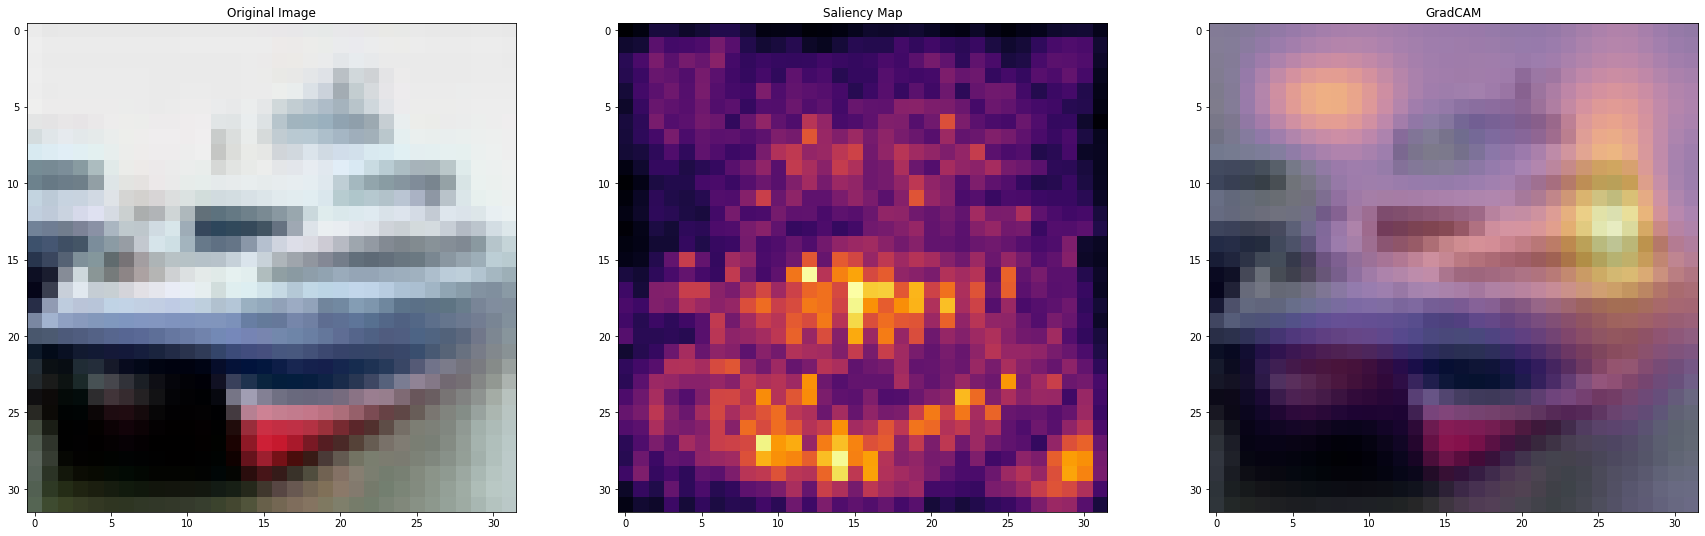

In [26]:
#plotting
fig, axs = plt.subplots(1,3,figsize=(30,9))
axs[0].imshow(X_test[image_id])
axs[0].title.set_text("Original Image")
axs[1].imshow(X_test[image_id])
axs[1].imshow(saliency_map[0,:,:],cmap='inferno')
axs[1].title.set_text("Saliency Map")
axs[2].imshow(X_test[image_id])
axs[2].imshow(cam[0,:,:],cmap='inferno', alpha=0.5)
axs[2].title.set_text("GradCAM")

Gradcam is clearer and is easier to demarcate regions of interest while the same can't be said for Saliency Map it is much more clustured and pixilated. They both are showing different aspects and features of the image.

#### Incorrect Classification

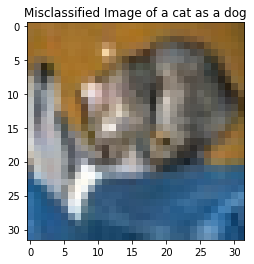

Correct Label: cat
Predicted Label: dog


In [27]:
mciid = 0 #MisClassified Image ID
mciid = np.where(y_pred.argmax(axis=1) != y_test.argmax(axis=1))[0][0] #u can also use this if u want same answer as the above

plt.title('Misclassified Image of a {} as a {}'.format(cifar10dict[np.argmax(y_test[mciid])],cifar10dict[np.argmax(y_pred[mciid])]))
plt.imshow(X_test[mciid])
plt.show()
print("Correct Label: {}".format(cifar10dict[np.argmax(y_test[mciid])]))
print("Predicted Label: {}".format(cifar10dict[np.argmax(y_pred[mciid])]))

In [28]:
#SALIENCY MAP
class_idx = y_test[mciid].argmax()
def loss(output):
    return output[:,class_idx]

#creating a Saliency object
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
saliency = Saliency(CNN, model_modifier = model_modifier, clone=True)

#Generate Saliency map
saliency_map = saliency(loss=loss,seed_input=X_test[mciid],smooth_samples=20,smooth_noise=0.20)

In [29]:
#GRADCAM
gradcam = Gradcam(CNN, model_modifier = model_modifier, clone=True)
#Genertate Heat map
cam = gradcam(loss,X_test[mciid],penultimate_layer=-1)

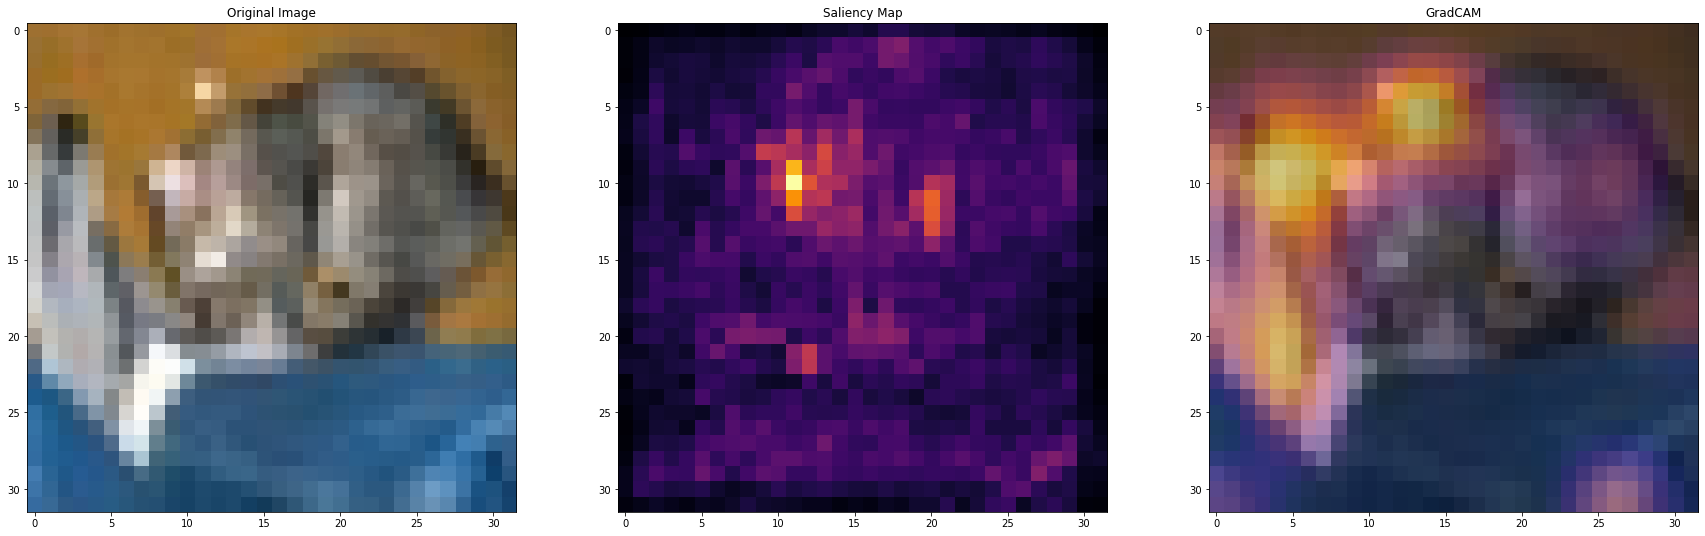

In [30]:
#plotting
fig, axs = plt.subplots(1,3,figsize=(30,9))
axs[0].imshow(X_test[mciid])
axs[0].title.set_text("Original Image")
axs[1].imshow(X_test[mciid])
axs[1].imshow(saliency_map[0,:,:],cmap='inferno')
axs[1].title.set_text("Saliency Map")
axs[2].imshow(X_test[mciid])
axs[2].imshow(cam[0,:,:],cmap='inferno',alpha=0.5)
axs[2].title.set_text("GradCAM")

In [31]:
a = np.argsort(y_pred[mciid])[::-1]
print('\t\tPrbability')
for i in a:
    proba = y_pred[mciid][i]
    print(f'{cifar10dict[i]}:  \t\t{proba:.8%}')

		Prbability
dog:  		47.87399173%
cat:  		47.22166657%
frog:  		2.85683051%
ship:  		0.88915071%
horse:  		0.30085184%
bird:  		0.28124589%
deer:  		0.25935641%
airplane:  		0.18001349%
automobile:  		0.06927165%
truck:  		0.06763281%


The reason behind the misclassification well the model seems to be focusing on the wrong aspect  of the Image causing it to misclassify the image. without going into case to case specific the model seems to be associating elements of the background with the object for example associating the black asphalt with automobiles and mistaking a ship for automobile when there is a dark shadow infront of the ship

Having more data could solve this misclassification problem, having more cases and background for each class.
OR remove all the backgrounds of all the images so the model learns to focus soley on the object of interest